# Evaluate Threshold Performance

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
import pandas as pd
import numpy as np
import sys
import pickle

In [107]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [108]:
from pcmasking.utils.setup import SetupDiagnostics
from pcmasking.utils.variable import Variable_Lev_Metadata
from pcmasking.neural_networks.load_models import load_models, get_save_plot_folder, load_single_model, get_path


In [109]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# training_91_mask_net_prediction_thresholds_spars0.001
# training_74_pre_mask_net_spars0.001

# training_103_mask_net_prediction_thresholds_spars0.001_plus4k
# training_101_pre_mask_net_spars0.001_plus4k

# training_104_mask_net_prediction_thresholds_spars0.001_minus4k
# training_102_pre_mask_net_spars0.001_minus4k
base_dir = os.path.join(PROJECT_ROOT, "output", "training_91_mask_net_prediction_thresholds_spars0.001")
pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output", "training_74_pre_mask_net_spars0.001")

cfg = os.path.join(base_dir, "cfg_mask_net.yml")
threshold_histories_dir = os.path.join(base_dir, "threshold_histories")

outputs_map_file = os.path.join(base_dir, "outputs_map.txt")

# History data from SingleNN 
# training_94_single_nn/
# training_107_single_nn_plus4k
# training_108_single_nn_minus4k
single_nn_bd = os.path.join(PROJECT_ROOT, "output", "training_94_single_nn")
performance_comparison_dir = os.path.join(single_nn_bd, "history")


In [110]:
def parse_txt_to_dict(txt_file, dict_key="varname"):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            
            if dict_key == "varname":
                line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
            else: 
                line_dict[value.lstrip().rstrip()] = key.lstrip().rstrip("\n")
                
    return line_dict

In [111]:
def load_pickle(p_file):
    with open(p_file, 'rb') as f:
        p_read = pickle.load(f)
    return p_read

In [112]:
def load_history_per_var(dir):
    histories_per_var = dict()
    
    for var_name in output_vars:
        threshold_file = os.path.join(dir, varname2index[var_name] + "_history.p")
    
        histories_per_var[var_name] = load_pickle(threshold_file)
    return histories_per_var


In [113]:
varname2index = parse_txt_to_dict(outputs_map_file)
index2varname = parse_txt_to_dict(outputs_map_file, dict_key="index")

output_vars =list(varname2index.keys())

In [114]:
histories_per_var = load_history_per_var(threshold_histories_dir)
perf_comp_dict = load_history_per_var(performance_comparison_dir)

## Plot Threshold Losses

In [115]:

def parse_label(dir_str):      
    if "training_88_mask_net_prediction_thresholds_spars1.0" in dir_str:
        return "MaskNet, ls=1.0"
    elif "training_89_mask_net_prediction_thresholds_spars0.1" in dir_str:
        return "MaskNet, ls=0.1"
    elif "training_90_mask_net_prediction_thresholds_spars0.01" in dir_str:
        return "MaskNet, ls=0.01"
    elif "training_91_mask_net_prediction_thresholds_spars0.001" in dir_str:
        return "MaskNet, ls=0.001"
    elif "training_92_mask_net_prediction_thresholds_spars1e-4" in dir_str:
        return "MaskNet, ls=1e-4"
    elif "training_93_mask_net_prediction_thresholds_spars1e-5" in dir_str:
        return "MaskNet, ls=1e-5"
    elif "training_103_mask_net_prediction_thresholds_spars0.001_plus4k" in dir_str: 
        return "MaskNet+4K, ls=0.001"
    elif "training_104_mask_net_prediction_thresholds_spars0.001_minus4k" in dir_str: 
        return "MaskNet-4K, ls=0.001"
    else:
        raise ValueError(f"Unknown directory string {dir_str}")


In [116]:

def plot_per_threshold(var_name, val=True, ymin=0., ymax=0.1):
    
    # Get data
    loss_per_threshold = dict()
    val_loss_per_threshold = dict()
    
    for t, metric in histories_per_var[var_name].items():
        loss_per_threshold[t] = metric['loss']
        val_loss_per_threshold[t] = metric['val_loss']
        
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 10))
    
    max_epochs = 18

    if val: 
        plot_threshold_loss = val_loss_per_threshold
        train_val = "validation"

        comp_loss = perf_comp_dict[var_name]['val_loss']
    else:
        plot_threshold_loss = loss_per_threshold
        train_val = "train"

        comp_loss = perf_comp_dict[var_name]['loss']
        
        
    for t, values in plot_threshold_loss.items():
        sns.lineplot(x=range(1, len(values)+1), y=values, label=f"{parse_label(base_dir)}, {train_val} loss, t={t:.4f}", ax=ax)

  
    sns.lineplot(x=range(1, len(comp_loss)+1), y=comp_loss, label=f"SingleNN, {train_val} loss", linestyle="dotted", ax=ax)
    ax.axhline(y=comp_loss[-1],  ls='dashed', label=f"Last SingleNN {train_val} loss")

    
    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDDDDD')
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=True, left=True)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    ax.margins(x=0.015)
    
    ax.set_ylim(bottom=ymin, top=ymax)

    
    ax.legend(title='Network', loc="upper right") #bbox_to_anchor=(1.01, 0.9))
        
    ax.set_xlabel('Epochs', labelpad=15, color='#333333')
    ax.set_ylabel('Training Loss', labelpad=15, color='#333333')

    if val: 
        ax.set_title(f'Validation Loss per Threshold for {var_name}', pad=15, color='#333333', weight='bold', fontsize=12)
    else: 
        ax.set_title(f'Training Loss per Threshold for {var_name}', pad=15, color='#333333', weight='bold', fontsize=12)

    save_dir = os.path.join(base_dir, "threshold_performance")
    Path(save_dir).mkdir(exist_ok=True, parents=True)
    save_png = f"{train_val}_loss_per_threshold_{var_name}.png"
    plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
    print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')
    
    plt.show()

In [117]:
print(base_dir)

/p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001



Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/train_loss_per_threshold_tphystnd-820.86.png.


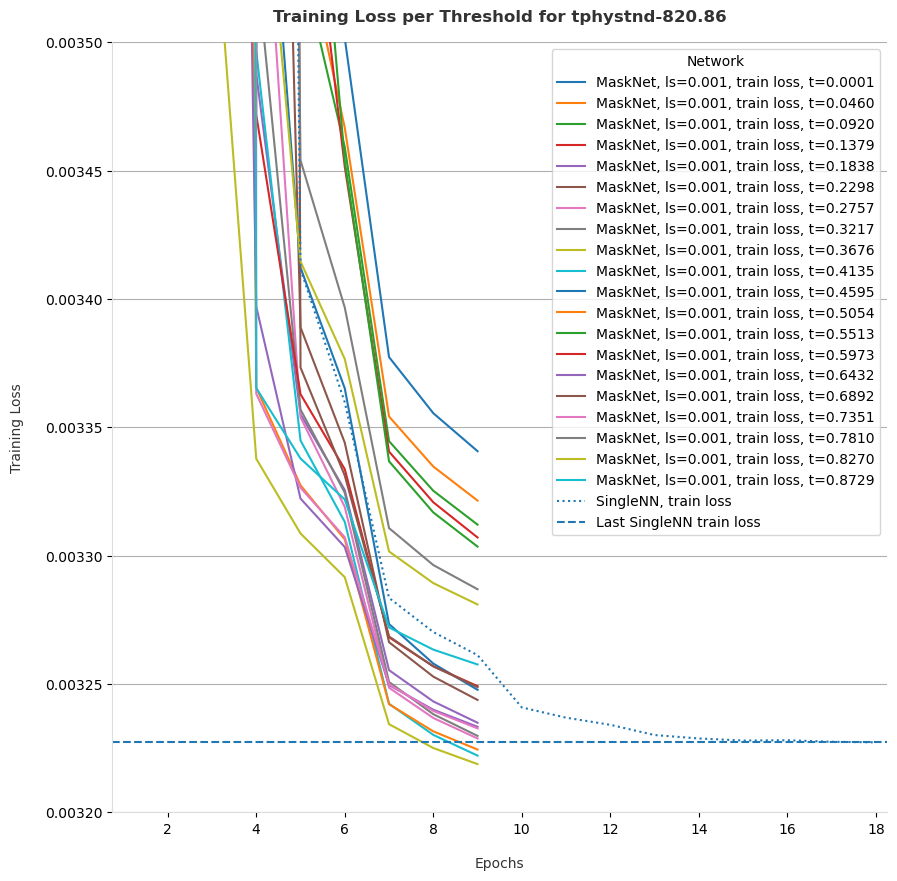

In [118]:
variable = "tphystnd-820.86"
plot_per_threshold(variable, val=False, ymin=0.0032, ymax=0.0035)


Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/validation_loss_per_threshold_tphystnd-820.86.png.


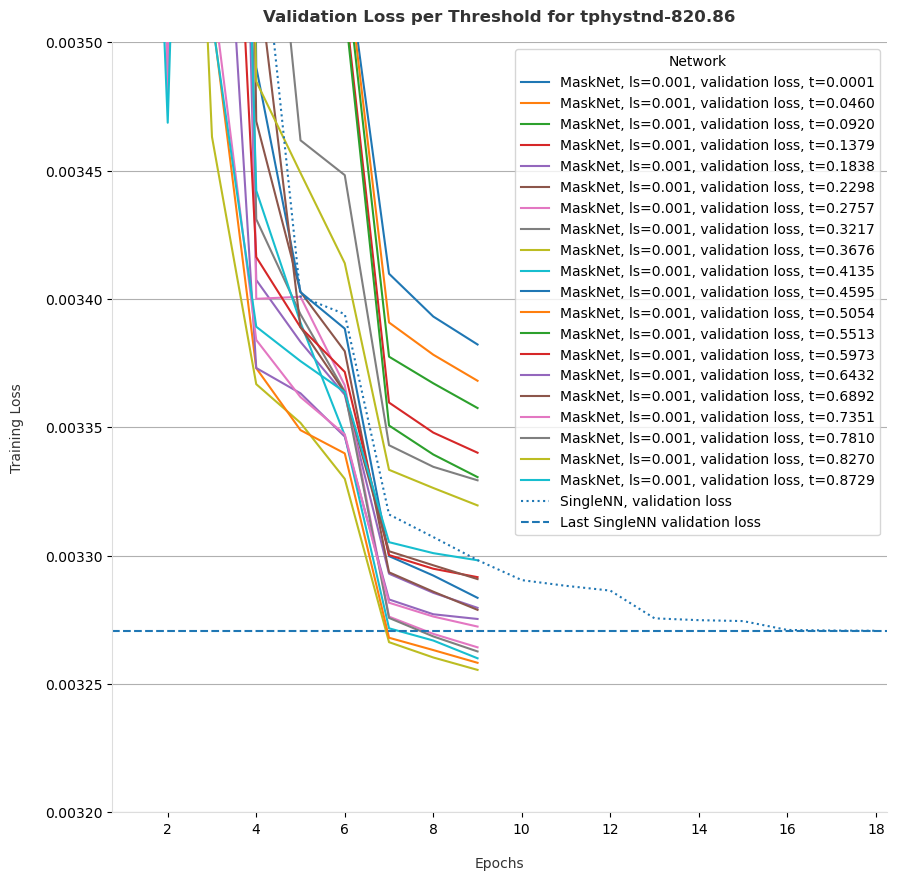

In [119]:
variable = "tphystnd-820.86"
plot_per_threshold(variable, val=True, ymin=0.0032, ymax=0.0035)


Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/train_loss_per_threshold_phq-820.86.png.


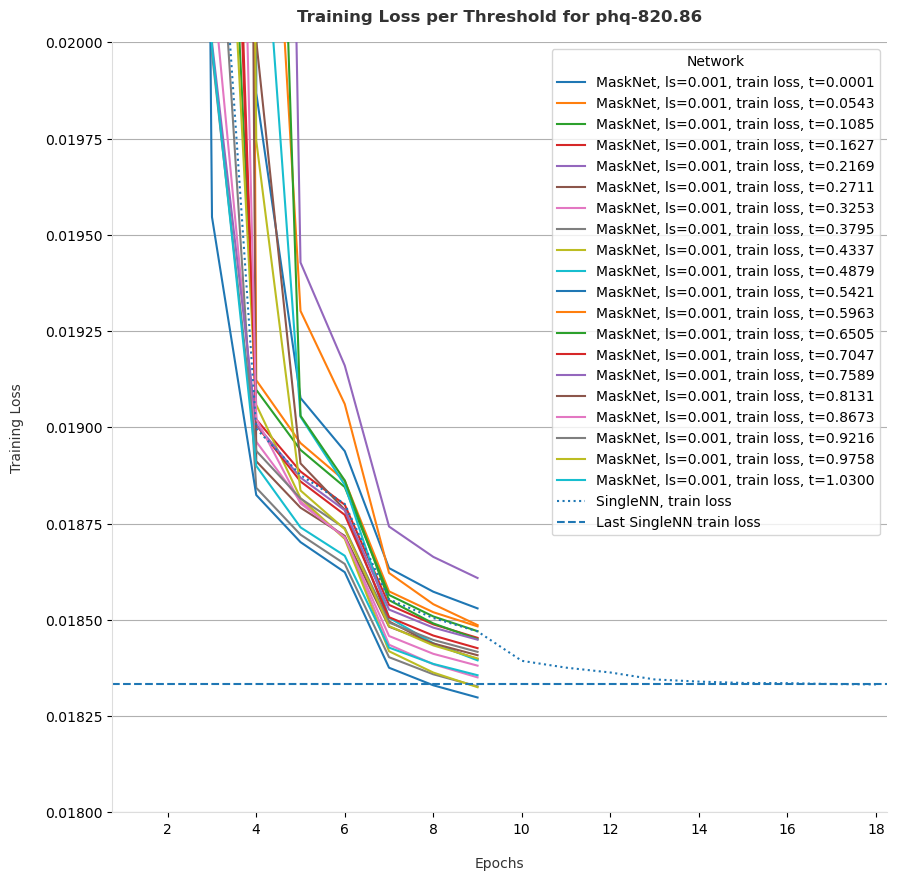

In [120]:
variable = "phq-820.86"
plot_per_threshold(variable, val=False, ymin=0.018, ymax=0.02)


Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/train_loss_per_threshold_prect.png.


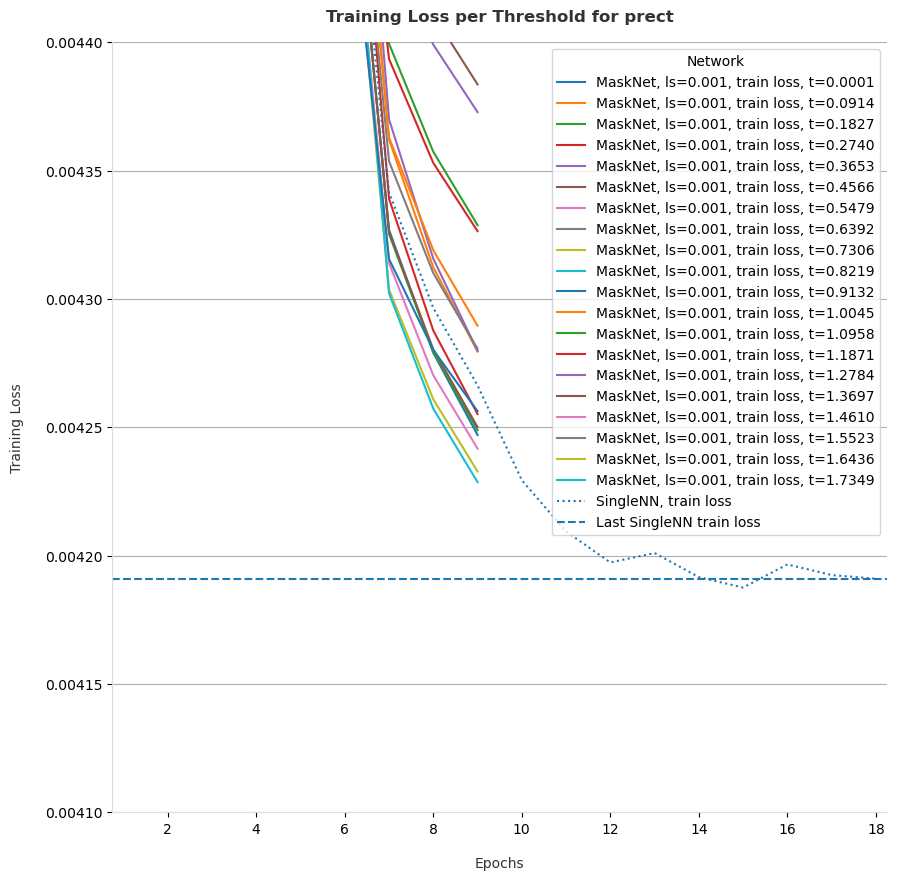

In [121]:
variable = "prect"
plot_per_threshold(variable, val=False, ymin=0.0041, ymax=0.0044)

## Best (min) Threshold Loss

In [122]:
def get_min_threshold_last_metric_element(d):

    # Use bigger threshold if the minima are the same
    current_min = 1000
    current_t = -1
    
    for key, history in d.items():
        v = round(history[-1], 6)
        
        if v < current_min: 
            current_min = v
            current_t = key
            
        elif v == current_min and key > t: 
            current_min = v
            current_t = key

    return current_t, current_min

In [123]:
threshold_per_var_train = dict()
threshold_per_var_val = dict()

for var in output_vars:

    # Get data
    loss_per_threshold = dict()
    val_loss_per_threshold = dict()
    
    for t, metric in histories_per_var[var].items():
        loss_per_threshold[t] = metric['loss']
        val_loss_per_threshold[t] = metric['val_loss']

    t_train, min_train = get_min_threshold_last_metric_element(loss_per_threshold)
    t_val, min_val = get_min_threshold_last_metric_element(val_loss_per_threshold)

    threshold_per_var_train[var] = t_train
    threshold_per_var_val[var] = t_val
    
        
    print(f"\n\nVariable {var}")

    print(f"\nThreshold = {t_train} for best last training loss = {min_train}")
    print(f"Threshold = {t_val} for best last validation loss = {min_val}")


    comp_pred_loss = perf_comp_dict[var]['loss']
    print(f"\nSingleNN training prediction loss = {comp_pred_loss[-1]}")
    val_comp_pred_loss = perf_comp_dict[var]['val_loss']
    print(f"SingleNN validation prediction loss = {val_comp_pred_loss[-1]}\n\n")




Variable tphystnd-3.64

Threshold = 0.0007 for best last training loss = 1e-06
Threshold = 0.0007 for best last validation loss = 1e-06

SingleNN training prediction loss = 1.5866272633502376e-06
SingleNN validation prediction loss = 1.707742399048584e-06




Variable tphystnd-7.59

Threshold = 0.0001 for best last training loss = 2e-06
Threshold = 0.0001 for best last validation loss = 2e-06

SingleNN training prediction loss = 1.5846192127355607e-06
SingleNN validation prediction loss = 1.8359859268457512e-06




Variable tphystnd-14.36

Threshold = 0.0001 for best last training loss = 0.000357
Threshold = 0.0001 for best last validation loss = 0.000372

SingleNN training prediction loss = 0.00035274974652566016
SingleNN validation prediction loss = 0.0003680580703075975




Variable tphystnd-24.61

Threshold = 0.0001 for best last training loss = 0.000177
Threshold = 0.0001 for best last validation loss = 0.000186

SingleNN training prediction loss = 0.00017462515097577125
SingleN

In [124]:
def plot_best_threshold(var_name, ymin=0., ymax=0.1):

    t_train = threshold_per_var_train[var_name]
    t_val = threshold_per_var_val[var_name]
    
    # Get data
    train_loss = histories_per_var[var_name][t_train]['loss']
    val_loss =  histories_per_var[var_name][t_val]['val_loss']

    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    max_epochs = 18
        
    sns.lineplot(x=range(1, len(train_loss)+1), y=train_loss, label=f"training loss tresholded t={t_train:.4f}", ax=ax)
    sns.lineplot(x=range(1, len(val_loss)+1), y=val_loss, label=f"validation loss tresholded t={t_val:.4f}", ax=ax)

    comp_train_pred_loss = perf_comp_dict[var_name]['loss']
    comp_val_pred_loss = perf_comp_dict[var_name]['val_loss']

    sns.lineplot(x=range(1, len(comp_train_pred_loss)+1), y=comp_train_pred_loss, label=f"SingleNN, training loss", linestyle="dashed", ax=ax)
    sns.lineplot(x=range(1, len(comp_val_pred_loss)+1), y=comp_val_pred_loss, label=f"SingleNN, validation loss", linestyle="dotted", ax=ax)
    ax.axhline(y=comp_train_pred_loss[-1],  ls='-.', label="Last SingleNN training loss")
          
    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDDDDD')
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=True, left=True)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    ax.margins(x=0.015)
    
    ax.set_ylim(bottom=ymin, top=ymax)
    
    ax.legend(title='Network', loc="best") # bbox_to_anchor=(1.01, 1.1))
        
    ax.set_xlabel('Epochs', labelpad=15, color='#333333')
    ax.set_ylabel('Loss', labelpad=15, color='#333333')

    ax.set_title(f'Best Threshold Loss for {var_name}', pad=15, color='#333333', weight='bold', fontsize=12)
    
    save_dir = os.path.join(base_dir, "threshold_performance")
    Path(save_dir).mkdir(exist_ok=True, parents=True)
    save_png = f"best_threshold_loss_{var_name}.png"
    plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
    print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')
    
    plt.show()


Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/best_threshold_loss_tphystnd-820.86.png.


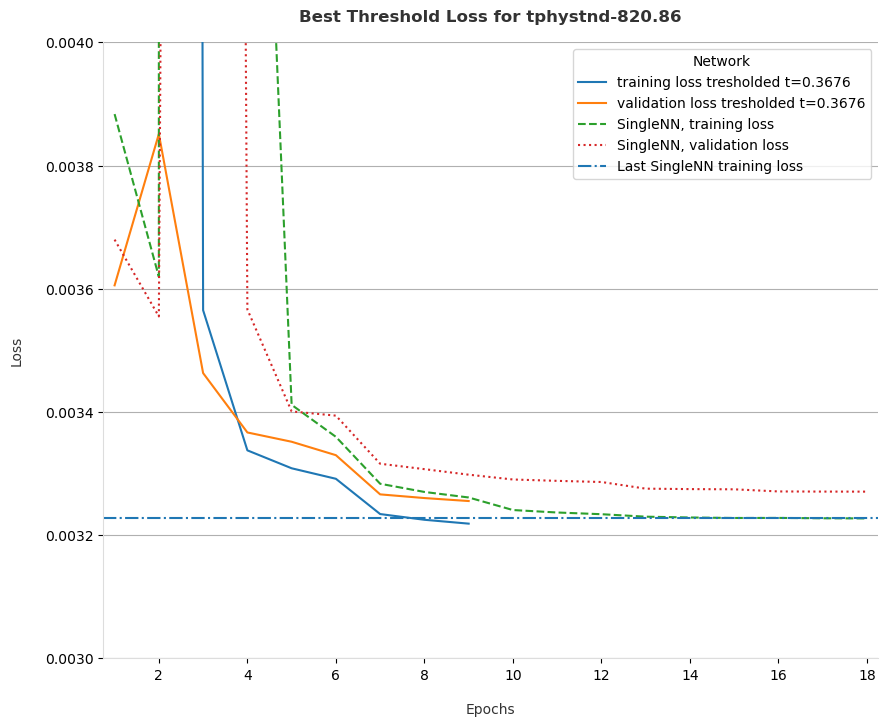

In [125]:
variable = "tphystnd-820.86"
plot_best_threshold(variable, ymin=0.003, ymax=0.004)


Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/best_threshold_loss_phq-820.86.png.


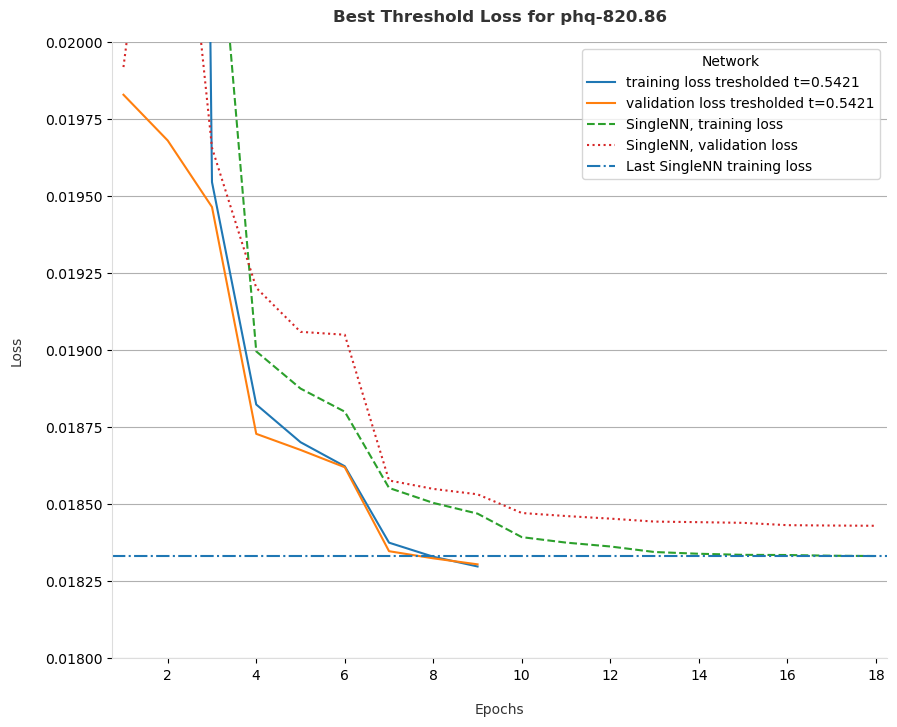

In [126]:
variable = "phq-820.86"
plot_best_threshold(variable, ymin=0.018, ymax=0.02)


Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/best_threshold_loss_prect.png.


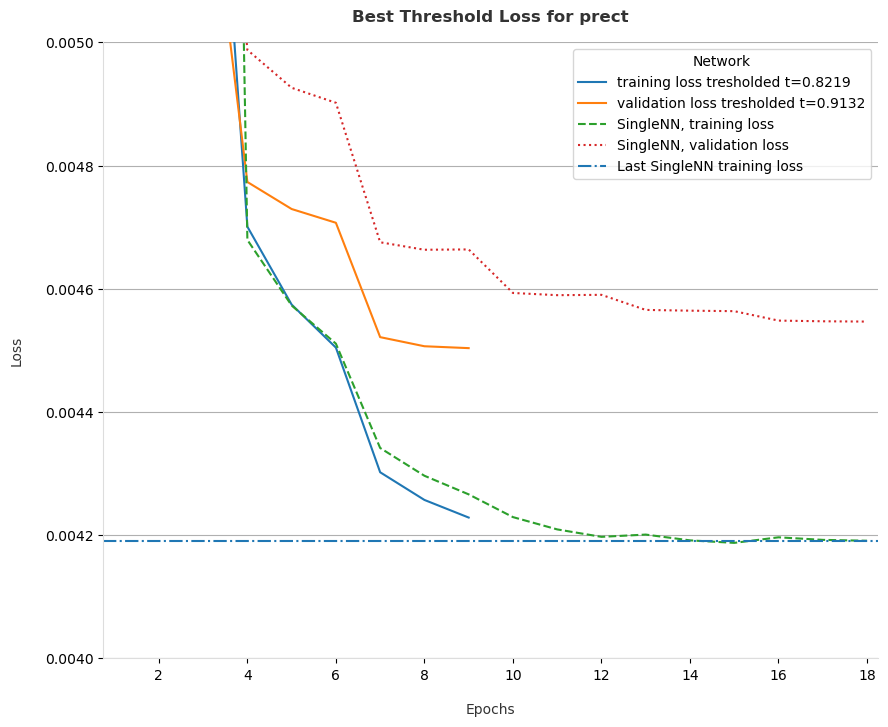

In [127]:
variable = "prect"
plot_best_threshold(variable, ymin=0.004, ymax=0.005)

## Plot Number of Inputs

In [128]:
causal_dir = os.path.join(PROJECT_ROOT, "output/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6")
with open(os.path.join(causal_dir, "num_inputs_per_var.p"), "rb") as f:
    causal_sums_per_var = pickle.load(f)

In [129]:
reference_dir = os.path.join(pre_mask_net_dir, "reference_thresholds")
with open(os.path.join(reference_dir, "num_inputs_per_var.p"), "rb") as f:
    reference_sums_per_var = pickle.load(f)
print(f"Loaded bespoke reference thresholds from {os.path.join(reference_dir, 'num_inputs_per_var.p')}")

Loaded bespoke reference thresholds from /p/scratch/icon-a-ml/kuehbacher1/output/training_74_pre_mask_net_spars0.001/reference_thresholds/num_inputs_per_var.p


In [130]:
masking_vector_dir = os.path.join(pre_mask_net_dir, "masking_vectors")
masking_vector_per_var = dict()
for var in output_vars: 
    masking_vector = np.load(os.path.join(masking_vector_dir, f"masking_vector_{var}.npy"))
    masking_vector_per_var[var] = masking_vector
print(f"Loaded masking vector from {masking_vector_dir}")

Loaded masking vector from /p/scratch/icon-a-ml/kuehbacher1/output/training_74_pre_mask_net_spars0.001/masking_vectors


In [131]:
def get_sum_inputs_for_threshold(thresholds_per_var):
    sum_per_var = dict()
    
    for var in output_vars:
        t = thresholds_per_var[var]
        masking_vector = masking_vector_per_var[var]
        
        t_vector = np.where(masking_vector < t, 
                            np.zeros_like(masking_vector, dtype=int), # value if condition true 
                            np.ones_like(masking_vector, dtype=int)) # value if condition false
        
        sum_per_var[var] = np.sum(t_vector)

    return sum_per_var

In [132]:
train_num_inputs_per_var = get_sum_inputs_for_threshold(threshold_per_var_train)
val_num_inputs_per_var = get_sum_inputs_for_threshold(threshold_per_var_val)


In [133]:
assert ([str(k) for k in causal_sums_per_var.keys()] == list(train_num_inputs_per_var.keys()))


Saving plot output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/number_of_inputs_per_var.png.


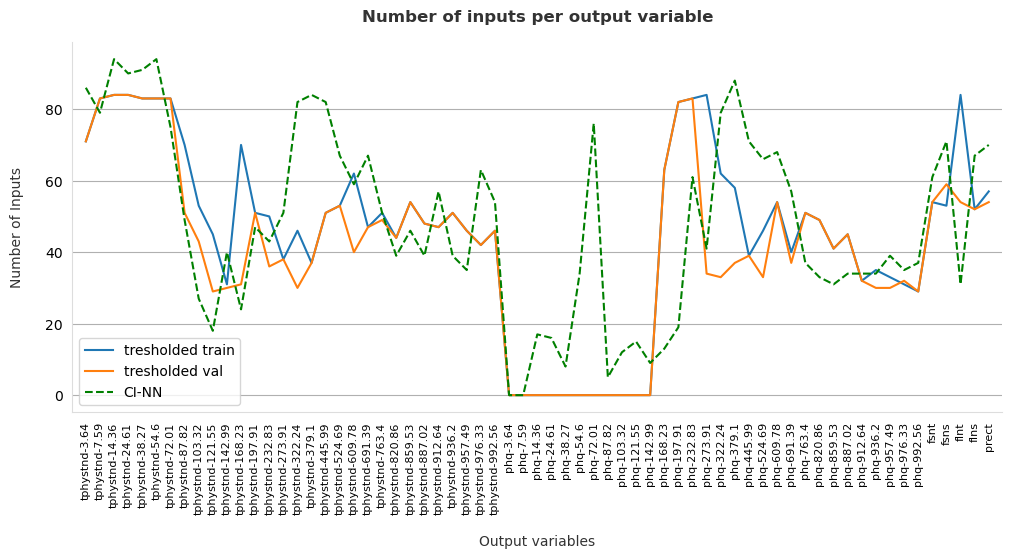

In [134]:
plt.close()
fig, ax = plt.subplots()
fig.set_figwidth(12)


x = range(len(output_vars))

sns.lineplot(x=x, y=train_num_inputs_per_var.values(), label="tresholded train", ax=ax)
sns.lineplot(x=x, y=val_num_inputs_per_var.values(), label="tresholded val", ax=ax)
# sns.lineplot(x=x, y=reference_sums_per_var.values(), label="reference threshold", linestyle="dotted", ax=ax)
sns.lineplot(x=x, y=causal_sums_per_var.values(), label="CI-NN", linestyle="dashed", ax=ax, color='green')
plt.legend()

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.margins(x=0.015)

ax.set_xticks(range(len(output_vars)))
ax.set_xticklabels(output_vars, rotation=90, ha='center', va='top')
    
ax.set_xlabel('Output variables', labelpad=15, color='#333333')
ax.set_ylabel('Number of Inputs', labelpad=15, color='#333333')

ax.set_title('Number of inputs per output variable', pad=15, color='#333333', weight='bold', fontsize=12)

save_dir = os.path.join(base_dir, "threshold_performance")
Path(save_dir).mkdir(exist_ok=True, parents=True)
save_png = f"number_of_inputs_per_var.png"
plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')

plt.show()

## Save Thresholds per var

In [135]:
output_dir = os.path.join(base_dir, "threshold_performance")
Path(output_dir).mkdir(exist_ok=True, parents=True)

In [136]:
def convert_keys_to_variables(per_var_dict):
    new_dict = dict()
    for key, value in per_var_dict.items():
        new_dict[Variable_Lev_Metadata.parse_var_name(key)] = value
    return new_dict

In [137]:
with open(os.path.join(output_dir, "threshold_per_var_train.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(threshold_per_var_train), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "threshold_per_var_train.p")).parts[-4:])}.')



Saved pickle file output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/threshold_per_var_train.p.


In [138]:
with open(os.path.join(output_dir, "threshold_per_var_val.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(threshold_per_var_train), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "threshold_per_var_val.p")).parts[-4:])}.')



Saved pickle file output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/threshold_per_var_val.p.


## Save Num Inputs per var

In [139]:
output_dir = os.path.join(base_dir, "threshold_performance")
Path(output_dir).mkdir(exist_ok=True, parents=True)

In [140]:
with open(os.path.join(output_dir, "num_inputs_per_var_train.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(train_num_inputs_per_var), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "num_inputs_per_var_train.p")).parts[-4:])}.')



Saved pickle file output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/num_inputs_per_var_train.p.


In [141]:
with open(os.path.join(output_dir, "num_inputs_per_var_val.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(val_num_inputs_per_var), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "num_inputs_per_var_val.p")).parts[-4:])}.')


Saved pickle file output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/num_inputs_per_var_val.p.
